## Image Transformation Pipeline (PyTorch)

Before feeding images into a neural network, we apply a sequence of transformations to ensure they are uniform, normalized, and tensorized. Here’s what each step does:

| Step | Transformation | Purpose | Notes |
|------|----------------|---------|-------|
| 1    | `transforms.Resize((64, 64))` | Resizes all images to 64×64 pixels | Neural networks require fixed-size inputs |
| 2    | `transforms.ToTensor()` | Converts image to PyTorch tensor (and scales pixel values from [0, 255] to [0, 1]) | Changes shape from (H, W, C) to (C, H, W) |
| 3    | `transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])` | Normalizes R, G, B channels to have values in [−1, +1] | Helps model converge faster with zero-centered inputs |

> Together, this pipeline ensures your image data is in the optimal format and scale for training a neural network.


In [3]:
#Transforms:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset
from collections import defaultdict
import torch
import random

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

#Loading the dataset:
#Automatically assigns labels & transforms: dog folder => label 0, etc
full_dataset = datasets.ImageFolder(root='raw-img', transform=transform)

#Balancing the dataset(Since more 1's are present):

## Splitting the Dataset
* Random Data split did not seem to work, so had to ask chatGPT to properly split the data for me for training and testing

In [4]:
# Group indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(full_dataset):
    class_indices[label].append(idx)

# Choose exactly 1446 samples from each class
target_count = 1446
selected_indices = []

for label, indices in class_indices.items():
    if len(indices) >= target_count:
        sampled = random.sample(indices, target_count)
        selected_indices.extend(sampled)
    else:
        raise ValueError(f"Not enough samples in class {label} to select {target_count}")

# Shuffle all selected indices
random.shuffle(selected_indices)

# Now, split into train/test (e.g., 80/20 split)
split_point = int(0.8 * len(selected_indices))
train_indices = selected_indices[:split_point]
test_indices = selected_indices[split_point:]

# Create Subsets
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Data Loader
* Mini-Batch Training
* Shuffling - Randomizes the data order
* Automatic batching - Done automatically by Pytorch

DataLoader is a utility that takes a dataset, splits it into mini-batches and feeds our model in chunks instead of all at once.

In [5]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=False)

## Coding the Neural Network
* Little bit of Theory by chatGPT:

##  Feedforward Neural Network Architecture

We define a custom neural network using PyTorch's `nn.Module` class. This network takes a flattened 64×64 RGB image (12288 features) and passes it through 3 fully connected (dense) layers with sigmoid activation functions.

###  Model Architecture

| Layer     | Description                            | Output Shape     |
|-----------|----------------------------------------|------------------|
| Flatten   | Converts 3D image (3×64×64) to 1D      | (12288,1)         |
| Linear 1  | Fully connected layer (12288 → 3)      | (3,1)             |
| Sigmoid   | Activation after Layer 1               | (3,1)             |
| Linear 2  | Fully connected layer (3 → 2)          | (2,1)             |
| Sigmoid   | Activation after Layer 2               | (2,1)             |
| Linear 3  | Fully connected layer (2 → 1)          | (1,1)             |
| Sigmoid   | Activation after output layer          | (1,1)             |

###  Explanation of Components

- `nn.Flatten()`  
  Flattens the 3D input tensor `(3, 64, 64)` to a 1D vector of size `12288`.

- `nn.Linear(input_dim, output_dim)`  
  A fully connected layer that learns weights and biases to transform data.

- `nn.Sigmoid()`  
  Activation function that squashes output to range (0, 1), suitable for binary classification.

###  Initialization

By default, PyTorch initializes weights using **Kaiming Uniform Initialization**, or **He Uniform Initialization**, which works well even with sigmoid in small networks.

Biases are initialised by default from a uniform distribution: bias ~ U(-1/sqrt(n_in),1/sqrt(n_in))

---


In [6]:
import torch.nn as nn
import torch.nn.functional as f

# #Our Feedforward NN:
# class AnimalClassifier(nn.Module):
#     def __init__(self):
#         super(AnimalClassifier, self).__init__()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64*64*3,3) #Linear Initialisation from X to first layer(3 neurons)
#         self.fc2 = nn.Linear(3,2)   #3 Neurons to 2 Neurons
#         #self.fc3 = nn.Linear(2,1)   #2 Neurons to 1 Neuron if binary
#         self.fc3 = nn.Linear(2,3)   #We are doing multi-class, not binary!!!
#         self.sigmoid = nn.Sigmoid() #Sigmoid is our activation function
    
#     def forward(self,x):
#         x = self.flatten(x) #Flattens pixels to a column vector
#         x = self.sigmoid(self.fc1(x)) #x now becomes a1(3x1 column vector)
#         x = self.sigmoid(self.fc2(x)) #x now becomes a2(2x1 column vector)
#         #x = self.sigmoid(self.fc3(x)) This was a mistake!!
#         x = self.fc3(x) #x now becomes y(hat), the prediction/final output
#         #Hidden layers: Sigmoid or ReLU
#         #Final output layer => When using CrossEntropyLoss, it is bad
#         #Because PyTorch expects raw scores(logits) from the last layer
#         #It automatically applies log(softmax) internally
#         return x

#The class above was using sigmoid, now let's use ReLU and MORE Neurons!
import torch.nn as nn
import torch.nn.functional as F

class AnimalClassifier(nn.Module):
    def __init__(self):
        super(AnimalClassifier, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 128)  # Input layer to hidden layer 1
        self.fc2 = nn.Linear(128, 64)           # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(64, 3)             # Hidden layer 2 to output (3 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)     # Flatten image tensor from [B, 3, 64, 64] to [B, 12288]
        x = F.relu(self.fc1(x))       # Apply ReLU after first hidden layer
        x = F.relu(self.fc2(x))       # Apply ReLU after second hidden layer
        x = self.fc3(x)               # Final layer, output raw logits
        return x


model = AnimalClassifier()



## Loss Function and Optimizer

### Binary Cross-Entropy Loss (BCELoss)

Since this is a **binary classification** task, we use the **Binary Cross-Entropy Loss** to measure how well the model is predicting 0 or 1.

**Formula:**
$$

\text{Loss} = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]

$$

- hat{y}  : predicted probability from the model
- \( y \): actual label (0 or 1)
In PyTorch:

```python
criterion = nn.BCELoss()







### Cross-Entropy Loss for Classification

Cross-entropy loss is a commonly used loss function for **classification tasks**. It measures the distance between the **true label distribution** and the **predicted probability distribution**.

---

#### 🔹 Single Example (Multi-Class)

The cross-entropy loss for a single training example is:

$$
\mathcal{L} = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

#### **Where:**
- L: Cross-entropy loss for a single example  
- \( C \): Total number of classes(Dog,Butterfly,Elephant) 
- \( y_i \): True label for class \( i \) (typically one-hot encoded: 1 for the correct class, 0 otherwise)  
- \( \hat{y}_i \): Predicted probability for class \( i \), usually the output of a softmax layer

---

####  Multiple Examples (Batch Loss)

For a batch of \( N \) examples, the average cross-entropy loss is:

$$
\mathcal{L}_{\text{avg}} = - \frac{1}{N} \sum_{j=1}^{N} \sum_{i=1}^{C} y_{j,i} \log(\hat{y}_{j,i})
$$

#### **Where:**
- \( \mathcal{L}_{\text{avg}} \): Average cross-entropy loss over the batch  
- \( N \): Number of examples in the batch  
- \( y_{j,i} \): True label for class \( i \) in example \( j \)  
- \( \hat{y}_{j,i} \): Predicted probability for class \( i \) in example \( j \)

---

####  Predicted Probabilities from Softmax

The predicted class probabilities \( \hat{y}_i \) are computed using the **softmax function** applied to the model's raw outputs (logits):

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{k=1}^{C} e^{z_k}}
$$

#### **Where:**
- z_i: Logit (raw model output) for class i, which is our logits, then we put this into the formula to calculate y(hat)
- The denominator ensures all \( \hat{y}_i \) are positive and sum to 1 (valid probability distribution)

---

####  Key Properties

- Cross-entropy loss is **low** when the predicted probability for the correct class is **high**
- It is **high** when the model is confident but **wrong**
- It is commonly used in combination with **softmax activation** in the final layer of classification models


### Optimizer — Stochastic Gradient Descent (SGD)

The optimizer is responsible for updating the model’s parameters (weights and biases) to reduce the loss.

We use **Stochastic Gradient Descent (SGD)**, which updates parameters using small batches of data (mini-batch gradient descent):

- Each batch is passed through the model
- Gradients are computed via backpropagation
- Parameters are updated to minimize the loss

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [7]:
import torch.optim as optim
import torch.nn as nn

#Loss function:
criterion = nn.CrossEntropyLoss() #Not binary!!! Very important!
#If our project was benign/malignant tumors, we use BCEloss() for our NLL



#Using Stochastic Gradient Descent(SGD), define learning rate also
optimizer = optim.SGD(model.parameters(), lr=0.01) 
#One other function to move your model to the GPU(Faster Training):
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#So now, we need to train this variable model that we created in previous code
#Training done with a concept called training loop, in next code


AnimalClassifier(
  (fc1): Linear(in_features=12288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

##  What is the Training Loop in Neural Networks?

The **training loop** is the core process that allows a neural network to learn from data. It’s a repeated cycle of:

1. **Forward Pass**: The model makes predictions on the input data.
2. **Loss Calculation**: We compute how wrong those predictions are using a loss function.
3. **Backward Pass**: Gradients (slopes) of the loss w.r.t. model parameters are calculated using backpropagation.
4. **Optimizer Step**: The optimizer updates the model’s weights and biases to reduce the loss.

This loop is repeated for multiple **epochs**, where:
- **1 epoch** = 1 full pass through the training dataset.

---

### 🔍 Why is this necessary?

- Neural networks start with random weights.
- The only way they learn is through **gradually adjusting** those weights to minimize error.
- Each pass through the loop helps the model make **better predictions**.

---

### 🧠 Training Loop Components Summary

| Step              | Description                                                  |
|-------------------|--------------------------------------------------------------|
| Forward Pass      | Model predicts output using current weights                  |
| Loss Calculation  | Measures how far predictions are from true values            |
| Backward Pass     | Computes how to change weights to reduce the loss            |
| Optimizer Step    | Applies those changes to update the model’s parameters       |
| Repeat for Epochs | Iterate over the entire dataset multiple times               |

---

> Without this loop, the neural network cannot improve — it would just keep guessing randomly.

> No. of iterations = epochs, similar to timesteps when using ABAQUS! the neural network cannot improve — it would just keep guessing randomly.

##  What is an Epoch in Machine Learning?

An **epoch** is **one complete pass** through the **entire training dataset**.

Imagine your model as a student studying a textbook (the dataset):
- **One epoch** = the student reads the entire book once.
- **Multiple epochs** = the student reads the book multiple times to better memorize and understand.

---

##  Why Do We Need Multiple Epochs?

- **First epoch**: The model starts with random guesses and learns basic patterns.
- **Subsequent epochs**: The model adjusts its internal weights and improves based on errors from the previous pass.
- With each pass, the model *learns from its mistakes* and gets better.

---

##  Effect of Increasing Epochs

- Initially: Training improves rapidly.
- Later: Improvements become smaller.
- Too many: Risk of **overfitting** — the model memorizes training data and fails on unseen data.

---

##  Epochs vs. Batches vs. Iterations

| Term       | Meaning                                               |
|------------|--------------------------------------------------------|
| **Epoch**  | One full pass over the training data                   |
| **Batch**  | A subset of the training data used for one update     |
| **Iteration** | One update of weights (one batch passed)           |

If you have 1000 images and use batch size 100:
- 1 epoch = 10 iterations

---

## ✅ Summary

- Increasing epochs lets the model learn **better patterns**.
- But you need to stop when loss stops improving (use early stopping or plotting).



In [8]:
#Training loop skeleton:
#num_epochs = 10 #Number of times we pass through the entire dataset => Loss was around 70-80
num_epochs = 40 #Now, let's use more epochs!
loss_values = []
for epoch in range(num_epochs):
    running_loss = 0.0 #Tracks total loss for a specific epoch

    #Now, in an epoch, we iterate over mini-batches of data
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device) #Moved to GPU!

            #Now, dog, which is 0 needs to become 0.0, Elephant which is 2->2.0
            #Convert to float so that we can add/subtract in BCE
            #labels = labels.float().unsqueeze(1)
        #But, we are doing CrossEntropyLoss!!!
        #So, we remove that line, keep it integer valued

        #Clear previous gradients for each epoch, we get a different value
        optimizer.zero_grad()

        #Forward pass first, using linear initialization, basically,
        #We put train_loader, which is a random batch of images into the model
        outputs = model(images) #So now, we have our prediction(yhat)
        loss = criterion(outputs,labels)
        #Now, computation of loss(Classification Cross-Entropy): Takes in the prediction(yhat) and label(y)
        #First mistake: this is for one class:  
        #For multi-class classification, we need to have a different loss:
        
        #Now, perform backpropagation, simply with 1 line, gradients calculated:
        loss.backward() 

        #For our optimizer function: weights and biases to be updated
        optimizer.step()

        #Now, for this batch for this epoch, add the loss onto running loss
        running_loss+= loss.item()
    
    #Now, let's see what the loss of each iteration/epoch is:
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")
    loss_values.append(running_loss)

#Now, printing predictions and targets:
images, labels = next(iter(train_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

print("Predictions:", preds[:10])
print("Targets    :", labels[:10])


Epoch 1/40, Loss: 56.8419
Epoch 2/40, Loss: 52.1096
Epoch 3/40, Loss: 49.4347
Epoch 4/40, Loss: 47.3518
Epoch 5/40, Loss: 45.5186
Epoch 6/40, Loss: 43.8531
Epoch 7/40, Loss: 42.3421
Epoch 8/40, Loss: 40.9593
Epoch 9/40, Loss: 39.6527
Epoch 10/40, Loss: 38.3954
Epoch 11/40, Loss: 37.1498
Epoch 12/40, Loss: 35.9048
Epoch 13/40, Loss: 34.6332
Epoch 14/40, Loss: 33.3402
Epoch 15/40, Loss: 32.0366
Epoch 16/40, Loss: 30.7158
Epoch 17/40, Loss: 29.3585
Epoch 18/40, Loss: 28.0224
Epoch 19/40, Loss: 26.6422
Epoch 20/40, Loss: 25.2979
Epoch 21/40, Loss: 23.9479
Epoch 22/40, Loss: 22.6426
Epoch 23/40, Loss: 21.4078
Epoch 24/40, Loss: 20.1509
Epoch 25/40, Loss: 18.9395
Epoch 26/40, Loss: 17.8447
Epoch 27/40, Loss: 16.6322
Epoch 28/40, Loss: 15.4242
Epoch 29/40, Loss: 14.1736
Epoch 30/40, Loss: 13.9989
Epoch 31/40, Loss: 14.7836
Epoch 32/40, Loss: 11.2062
Epoch 33/40, Loss: 11.2575
Epoch 34/40, Loss: 10.6962
Epoch 35/40, Loss: 13.6622
Epoch 36/40, Loss: 8.3442
Epoch 37/40, Loss: 7.5938
Epoch 38/40,

### Testing Model Accuracy

[[155  79  41]
 [ 34 201  87]
 [ 28  60 183]]


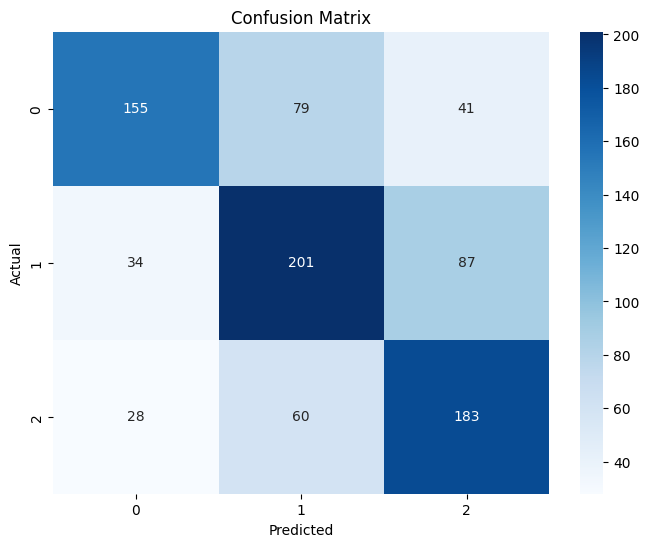

              precision    recall  f1-score   support

   butterfly       0.71      0.56      0.63       275
         dog       0.59      0.62      0.61       322
    elephant       0.59      0.68      0.63       271

    accuracy                           0.62       868
   macro avg       0.63      0.62      0.62       868
weighted avg       0.63      0.62      0.62       868



In [9]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
model.eval() #Evaluation mode

#For collecting all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images) #Forward Pass
        _, predicted = torch.max(outputs.data,1) #Choose class with highest score as prediction
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
#Confusion Matrix:
cm = confusion_matrix(all_labels, all_preds)
print(cm)
#Plotting:
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
class_names = full_dataset.classes
print(classification_report(all_labels, all_preds, target_names=class_names))



### Results: (Loss vs Epochs Plot)

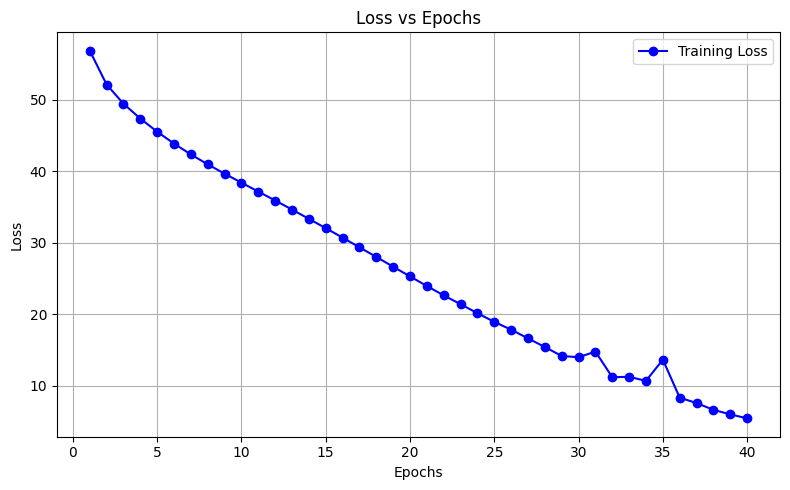

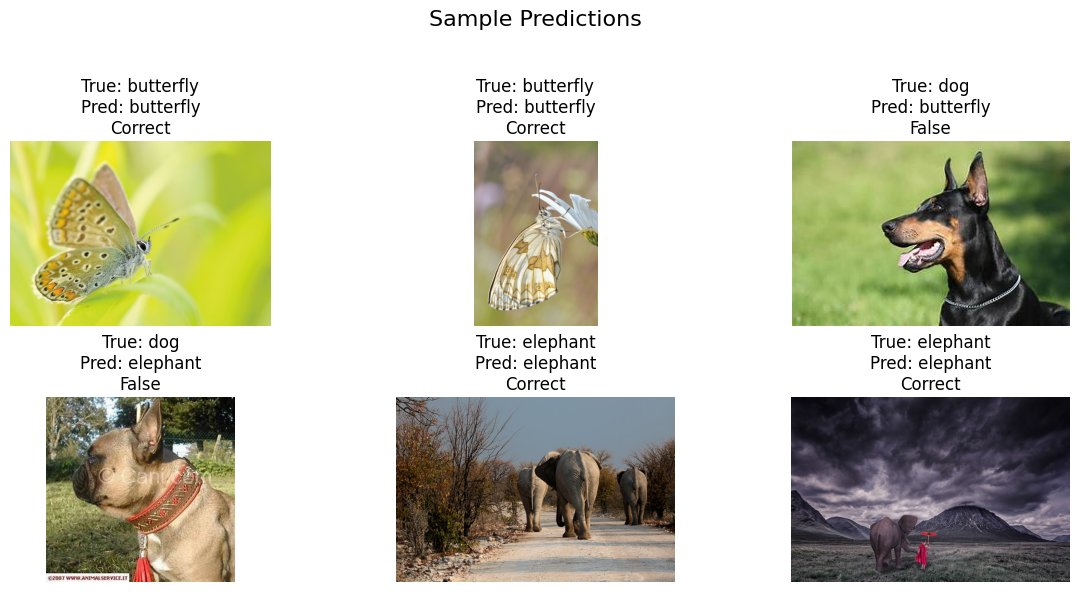

In [10]:
import numpy as np
from PIL import Image
import torch
plt.figure(figsize = (8,5))
plt.plot(range(1,len(loss_values)+1),loss_values,marker='o',color='blue',label='Training Loss')

#Adding Labels:
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

#Show:
plt.tight_layout()
plt.show()


#Sample Predictions Grid:
image_paths = [
    r"C:\Users\aadii\OneDrive\Desktop\Github\MLStuff\ImageClassificationWithNN\raw-img\butterfly\e030b20a20e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg",
    r"C:\Users\aadii\OneDrive\Desktop\Github\MLStuff\ImageClassificationWithNN\raw-img\butterfly\e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg",
    r"C:\Users\aadii\OneDrive\Desktop\Github\MLStuff\ImageClassificationWithNN\raw-img\dog\OIP-_-AtcUnGMN6ht4EYKmgkXgHaE8.jpeg",
    r"C:\Users\aadii\OneDrive\Desktop\Github\MLStuff\ImageClassificationWithNN\raw-img\dog\OIP-zYvaE-5JACx0_d0Z3VoxBwHaHS.jpeg",
    r"C:\Users\aadii\OneDrive\Desktop\Github\MLStuff\ImageClassificationWithNN\raw-img\elephant\e83cb00a2ef1083ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg",
    r"C:\Users\aadii\OneDrive\Desktop\Github\MLStuff\ImageClassificationWithNN\raw-img\elephant\e83db60c2cf7083ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.jpg"
]
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

from PIL import Image
import torch
#Function for predicting image and returning the name of class
def predict_image(path, model, transform, class_names):
    image = Image.open(path).convert("RGB") #Opens the image, store into image
    image = transform(image).unsqueeze(0)  # shape: (1, C, H, W) transform it
    model.eval() #Evaluation mode
    with torch.no_grad():
        output = model(image) #Outputs the raw logits after evaluating loss function L
        _, predicted = torch.max(output, 1) #_ is X and predicted is y, so we need only y
        return class_names[predicted.item()]  # return class label string
    
#Now, we have to assign 0 to butterfly, 1 to dog, 2 to elephant:
class_names = full_dataset.classes #Class names is now an array of all labels available
#Getting the predicted labels:

predicted_labels = [predict_image(path, model, transform, class_names) for path in image_paths]
true_labels = ['butterfly','butterfly','dog','dog','elephant','elephant']
#Seems to have gotten 4 out of 6 correct
#Displaying our grid:
plt.figure(figsize=(12,6))
for i,path in enumerate(image_paths):
    img = Image.open(path).convert("RGB")
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    if predicted_labels[i] == true_labels[i]:
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}\nCorrect")
    else:
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}\nFalse") #If it is wrong prediction
plt.suptitle("Sample Predictions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Conclusion:
The original goal of this project was to build a basic feedforward neural network to classify animal images (`dog`, `elephant`, `butterfly`) from the Animals-10 dataset. Throughout the development process, several key modifications were made to improve model performance, stability, and training correctness. Below is a complete list of all refinements and theoretical insights added along the way:

## 1. Model Architecture Enhancements

| Update | Description |
|--------|-------------|
| **Increased Neurons** | Changed architecture from a minimal 3-2-1 structure to a deeper network with more neurons in each layer, enabling the model to learn more complex patterns. |
| **Changed Activation to ReLU** | Replaced `Sigmoid` with `ReLU` in hidden layers for better convergence, especially in deeper networks. |
| **Reason** | ReLU avoids the vanishing gradient problem and speeds up training compared to Sigmoid. |
| **Final Output Layer** | For multi-class output, the final layer outputs raw logits instead of sigmoid probabilities. |

## 2. Loss Function Transition

### 🔄 Why We Changed the Loss Function

| Aspect                  | Details                                                                 |
|-------------------------|-------------------------------------------------------------------------|
| **Initial Choice**      | `Binary Cross Entropy (BCE)`                                            |
| **Issue**               | BCE is only suitable for **binary classification** tasks.               |
|                         | We are solving a **multi-class** problem (e.g., dog, butterfly, elephant). |
| **Problem Faced**       | Using BCE led to errors due to incorrect output and target shapes.      |
| **Final Choice**        | Switched to `CrossEntropyLoss()` — designed for multi-class classification. |
| **Result**              | Model now accepts raw logits and properly computes multi-class loss.    |

---

### 🧮 Key Differences

| Loss Type                  | Formula                                                                 | Notes                                                                 |
|---------------------------|-------------------------------------------------------------------------|-----------------------------------------------------------------------|
| **Binary Cross Entropy**  | `- [ y * log(ŷ) + (1 - y) * log(1 - ŷ) ]`                             | Expects probabilities (`ŷ` in [0, 1]), typically used with `Sigmoid`.|
| **Categorical Cross Entropy** | `-log( e^{z_k} / ∑ e^{z_j} )`<br> → `-log(Softmax(logits)[k])`        | Expects raw logits (no softmax needed). Best for multi-class output. |

---

> ✅ `CrossEntropyLoss()` is appropriate for classification problems where each input belongs to **exactly one class out of many**.


## 3. Training Loop and Optimizer

| Element | Explanation |
|---------|-------------|
| **Loss Tracking** | Implemented per-epoch loss reporting to observe convergence over time. |
| **Optimizer Used** | `Stochastic Gradient Descent (SGD)` with fixed learning rate. |
| **Epoch Intuition** | Explained epochs as "full passes through the dataset", allowing the model to iteratively refine weights. |
| **Overfitting Risk** | Discussed how increasing epochs too much can lead to overfitting on training data. |

## 4. Output Interpretation Fix

| Update | Explanation |
|--------|-------------|
| **Model Output (`ŷ`)** | Clarified that logits (not probabilities) should be passed to `CrossEntropyLoss`. |
| **Prediction Strategy** | After training, `argmax` was used to convert logits into predicted labels. |

## 5. Evaluation Improvements

| Topic | Details |
|-------|---------|
| **Confusion Matrix** | Used to evaluate class-wise performance. |
| **Accuracy Metric** | Implemented to check model's overall predictive success. |
| **Precision/Recall Discussion** | Discussed their role in imbalanced datasets (though not yet implemented). |

## 6. Dataset Management Fixes

| Fix | Description |
|-----|-------------|
| **Unbalanced Labels** | Identified severe class imbalance (e.g., 1446 dog images vs. 300 others). |
| **Solution** | Balanced the dataset by sampling an equal number (e.g., 1446) from each class. |
| **Manual Verification** | Counted class-wise samples to confirm balance before training. |

## Final Remarks

This iterative project evolved from a basic neural net to a well-structured, multi-class classification system with correct architectural, loss function, and dataset handling strategies. Each improvement addressed a specific challenge:

- Inappropriate loss function → switched to `CrossEntropyLoss`
- Vanishing gradients → switched to `ReLU`
- Class imbalance → fixed with balanced sampling
- Output mismatch → corrected with `argmax` + logits

> The process has strengthened both your understanding of neural networks and your practical skills in debugging and refining real-world ML systems.

| **Metric**      | **Formula**                                                                 | **Meaning**                                                                 |
|-----------------|------------------------------------------------------------------------------|------------------------------------------------------------------------------|
| **Precision**   | TP / (TP + FP)                                                               | Of all the samples **predicted** as a class, how many were **actually correct**? |
| **Recall**      | TP / (TP + FN)                                                               | Of all the samples that are **actually** a class, how many did the model **correctly predict**? |
| **F1 Score**    | 2 × (Precision × Recall) / (Precision + Recall)                             | Harmonic mean of Precision and Recall. Balances both false positives and false negatives. |
| **Support**     | Count of actual samples of the class                                         | How many times the class appeared in the **true labels** (i.e., ground truth). |
